## VGGNet and INCEPTION network mix based Network

In [11]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import cv2 as cv

import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, concatenate
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.utils import plot_model, save_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
base_dir = '../input'

In [3]:
cassava_dir = os.path.join(base_dir, 'cassava-leaf-disease-classification')
plant_village_dir = os.path.join(base_dir, 'plantvillage-dataset')
rice_dir = os.path.join(base_dir, 'rice-leaf-images/rice_images')

In [4]:
fnames = []

for dir in os.listdir(os.path.join(plant_village_dir, 'color')):
    columns = dir.split('___')
    columns.append(dir)
    fnames.append(columns)

In [5]:
fnames = pd.DataFrame(fnames, columns=['Tree type', 'Disease', 'Folder'])
fnames

In [6]:
fnames.drop([4, 17, 33], axis=0, inplace=True)

In [7]:
fnames['Disease'] = fnames['Disease'].str.replace('_', ' ')
fnames['Disease'] = fnames['Disease'].str.lstrip()
fnames['Tree type'] = fnames['Tree type'].str.replace('_', ' ')
fnames['Tree type'] = fnames['Tree type'].str.lstrip()
fnames

In [8]:
os.mkdir('image data')

In [9]:
os.mkdir(os.path.join('image data', 'train'))
os.mkdir(os.path.join('image data', 'validation'))
os.mkdir(os.path.join('image data', 'test'))

In [10]:
train_path = os.path.join('image data/train')
val_path = os.path.join('image data/validation')
test_path = os.path.join('image data/test')

In [11]:
for tree in fnames['Tree type'].unique().tolist():
    # create directory for tree
    path_1 = os.path.join(train_path, tree)
    path_2 = os.path.join(test_path, tree)
    path_3 = os.path.join(val_path, tree)

    os.mkdir(path_1)
    os.mkdir(path_2)
    os.mkdir(path_3)

    for disease, folder in fnames[fnames['Tree type'] == tree][['Disease', 'Folder']].values.tolist():
        # create directory to each disease
        sub_path_1 = os.path.join(path_1, disease.strip())
        sub_path_2 = os.path.join(path_2, disease.strip())
        sub_path_3 = os.path.join(path_3, disease.strip())

        os.mkdir(sub_path_1)
        os.mkdir(sub_path_2)
        os.mkdir(sub_path_3)

        # read data from source folder
        src = os.path.join(plant_village_dir, 'color', folder)
        image_count = len(os.listdir(src))
        test_img_count = image_count // 10
        val_img_count = (image_count - test_img_count) // 5
        train_img_count = image_count - (test_img_count + val_img_count)
        counts = [train_img_count, test_img_count, val_img_count]
        splits = [sub_path_1, sub_path_2, sub_path_3]

        for i in range(3):
            images = os.listdir(src)
            for j in images[:counts[i]]:
                shutil.copyfile(src=os.path.join(src, j),
                                dst=os.path.join(splits[i], j))

In [12]:
os.mkdir(os.path.join(train_path, 'Rice'))
os.mkdir(os.path.join(test_path, 'Rice'))
os.mkdir(os.path.join(val_path, 'Rice'))

In [13]:
source_dirs = os.listdir(rice_dir)

for source in source_dirs:
    src = os.path.join(rice_dir, source)
    image_count = len(os.listdir(src))
    test_img_count = image_count // 10
    val_img_count = (image_count - test_img_count) // 5
    train_img_count = image_count - (test_img_count + val_img_count)
    path_1 = os.path.join('image data/train/Rice', source.replace('_', ''))
    path_2 = os.path.join('image data/test/Rice', source.replace('_', ''))
    path_3 = os.path.join('image data/validation/Rice', source.replace('_', ''))

    os.mkdir(path_1)
    os.mkdir(path_2)
    os.mkdir(path_3)
    paths = [path_1, path_2, path_3]
    split_counts = [train_img_count, test_img_count, val_img_count]

    for i in range(3):
        images = os.listdir(src)
        for j in images[:split_counts[i]]:
            shutil.copyfile(src=os.path.join(src, j),
                            dst=os.path.join(paths[i], j))

In [14]:
disease_map = {0: "Bacterial Blight (CBB)",
               1: "Brown Streak Disease (CBSD)",
               2: "Green Mottle (CGM)",
               3: "Mosaic Disease (CMD)",
               4: "Healthy"}

In [15]:
pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')['label'].value_counts()

In [16]:
os.mkdir(os.path.join(train_path, 'Cassava'))
os.mkdir(os.path.join(test_path, 'Cassava'))
os.mkdir(os.path.join(val_path, 'Cassava'))

In [17]:
for disease in disease_map.values():
    os.mkdir(os.path.join('image data/train/Cassava', disease))
    os.mkdir(os.path.join('image data/test/Cassava', disease))
    os.mkdir(os.path.join('image data/validation/Cassava', disease))

In [18]:
df = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')

for img in df[df['label'] == 0].reset_index().loc[:378, 'image_id']:
    src = os.path.join(cassava_dir, 'train_images', img)
    dst = os.path.join('image data/train/Cassava', disease_map[0], img)

    if os.path.isfile(src):
        img_ = img_to_array(load_img(src))
        cropped = tf.image.central_crop(img_, central_fraction=0.65)
        save_img(dst, cv.resize(src=img_to_array(cropped), dsize=(256, 256)))

for img in df[df['label'] == 0].reset_index().loc[378:486, 'image_id']:
    src = os.path.join(cassava_dir, 'train_images', img)
    dst = os.path.join('image data/test/Cassava', disease_map[0], img)

    if os.path.isfile(src):
        img_ = img_to_array(load_img(src))
        cropped = tf.image.central_crop(img_, central_fraction=0.65)
        save_img(dst, cv.resize(src=img_to_array(cropped), dsize=(256, 256)))

for img in df[df['label'] == 0].reset_index().loc[486:540, 'image_id']:
    src = os.path.join(cassava_dir, 'train_images', img)
    dst = os.path.join('image data/validation/Cassava', disease_map[0], img)

    if os.path.isfile(src):
        img_ = img_to_array(load_img(src))
        cropped = tf.image.central_crop(img_, central_fraction=0.65)
        save_img(dst, cv.resize(src=img_to_array(cropped), dsize=(256, 256)))

In [19]:
for i in range(1, 4):
    for img in df[df['label'] == i].reset_index().loc[:448, 'image_id']:
        src = os.path.join(cassava_dir, 'train_images', img)
        dst = os.path.join('image data/train/Cassava', disease_map[i], img)

        if os.path.isfile(src):
            img_ = img_to_array(load_img(src))
            cropped = tf.image.central_crop(img_, central_fraction=0.65)
            save_img(dst, cv.resize(src=img_to_array(cropped), dsize=(256, 256)))

    for img in df[df['label'] == i].reset_index().loc[448:572, 'image_id']:
        src = os.path.join(cassava_dir, 'train_images', img)
        dst = os.path.join('image data/test/Cassava', disease_map[i], img)

        if os.path.isfile(src):
            img_ = img_to_array(load_img(src))
            cropped = tf.image.central_crop(img_, central_fraction=0.65)
            save_img(dst, cv.resize(src=img_to_array(cropped), dsize=(256, 256)))

    for img in df[df['label'] == i].reset_index().loc[572:634, 'image_id']:
        src = os.path.join(cassava_dir, 'train_images', img)
        dst = os.path.join('image data/validation/Cassava', disease_map[i], img)

        if os.path.isfile(src):
            img_ = img_to_array(load_img(src))
            cropped = tf.image.central_crop(img_, central_fraction=0.65)
            save_img(dst, cv.resize(src=img_to_array(cropped), dsize=(256, 256)))

In [20]:
for img in df[df['label'] == 4].reset_index().loc[:708, 'image_id']:
    src = os.path.join(cassava_dir, 'train_images', img)
    dst = os.path.join('image data/train/Cassava', disease_map[4], img)

    if os.path.isfile(src):
        img_ = img_to_array(load_img(src))
        cropped = tf.image.central_crop(img_, central_fraction=0.65)
        save_img(dst, cv.resize(src=img_to_array(cropped), dsize=(256, 256)))

for img in df[df['label'] == 4].reset_index().loc[708:910, 'image_id']:
    src = os.path.join(cassava_dir, 'train_images', img)
    dst = os.path.join('image data/test/Cassava', disease_map[4], img)

    if os.path.isfile(src):
        img_ = img_to_array(load_img(src))
        cropped = tf.image.central_crop(img_, central_fraction=0.65)
        save_img(dst, cv.resize(src=img_to_array(cropped), dsize=(256, 256)))

for img in df[df['label'] == 4].reset_index().loc[910:1011, 'image_id']:
    src = os.path.join(cassava_dir, 'train_images', img)
    dst = os.path.join('image data/validation/Cassava', disease_map[4], img)

    if os.path.isfile(src):
        img_ = img_to_array(load_img(src))
        cropped = tf.image.central_crop(img_, central_fraction=0.65)
        save_img(dst, cv.resize(src=img_to_array(cropped), dsize=(256, 256)))

## modeling

In [21]:
X = []
y = []
val_x = []
val_y = []
test_x = []
test_y = []
tree_types = os.listdir('image data/train')

for tree in tree_types:
    tree_path = os.path.join('image data/train', tree)
    tree_disease_types = os.listdir(tree_path)

    for disease in tree_disease_types:
        img_name = os.listdir(os.path.join(tree_path, disease))

        for img in img_name:
            image_path = os.path.join(tree_path, disease, img)
            image = cv.resize(cv.imread(image_path), dsize=(56, 56))
            X.append(image)
            y.append([tree, disease])

for tree in tree_types:
    tree_path = os.path.join('image data/validation', tree)
    tree_disease_types = os.listdir(tree_path)

    for disease in tree_disease_types:
        img_name = os.listdir(os.path.join(tree_path, disease))

        for img in img_name:
            image_path = os.path.join(tree_path, disease, img)
            image = cv.resize(cv.imread(image_path), dsize=(56, 56))
            val_x.append(image)
            val_y.append([tree, disease])

for tree in tree_types:
    tree_path = os.path.join('image data/test', tree)
    tree_disease_types = os.listdir(tree_path)

    for disease in tree_disease_types:
        img_name = os.listdir(os.path.join(tree_path, disease))

        for img in img_name:
            image_path = os.path.join(tree_path, disease, img)
            image = cv.resize(cv.imread(image_path), dsize=(56, 56))
            test_x.append(image)
            test_y.append([tree, disease])

In [22]:
mlb = MultiLabelBinarizer()

X = np.array(X)
val_x = np.array(val_x)
y = mlb.fit_transform(y)
val_y = mlb.transform(val_y)
test_y = mlb.transform(test_y)
test_x = np.array(test_x) / 255
val_x = val_x / 255
X.shape, y.shape

In [23]:
generator = ImageDataGenerator(rescale=1. / 255,
                               rotation_range=15,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True
                               )
generator.fit(X)

In [24]:
check_pointer = ModelCheckpoint(filepath='exp_conv_8.hdf5',
                                save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=40,
                           min_delta=0,
                           restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=20)

In [16]:
base_filters = 32
input_layer = Input(shape=(56, 56, 3))

# conv 1
c1 = Conv2D(filters=base_filters * 2, kernel_size=(5, 5), padding='same', activation=relu)(input_layer)
bn1 = BatchNormalization()(c1)

# conv 2
c2 = Conv2D(filters=base_filters * 2, kernel_size=(5, 5), padding='same', activation=relu)(bn1)
bn2 = BatchNormalization()(c2)

# pooling and dropout
mp1 = MaxPooling2D(pool_size=(2, 2))(bn2)
do1 = Dropout(0.2)(mp1)

# inception module

# top layer
c2 = Conv2D(filters=base_filters * 2, kernel_size=(1, 1), padding='same', activation=relu)(do1)
c3 = Conv2D(filters=base_filters * 3, kernel_size=(1, 1), padding='same', activation=relu)(do1)
c4 = Conv2D(filters=base_filters // 2, kernel_size=(1, 1), padding='same', activation=relu)(do1)
mp2 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(do1)

# dimensional reduction layer
c5 = Conv2D(filters=base_filters * 4, kernel_size=(3, 3), padding='same', activation=relu)(c3)
c6 = Conv2D(filters=base_filters, kernel_size=(5, 5), padding='same', activation=relu)(c4)
c7 = Conv2D(filters=base_filters, kernel_size=(1, 1), padding='same', activation=relu)(mp2)

# depth concatenation
con1 = concatenate([c2, c5, c6, c7], axis=3)

# conv 3
c8 = Conv2D(filters=base_filters * 4, kernel_size=(5, 5), padding='same', activation=relu)(con1)
bn3 = BatchNormalization()(c8)

# conv 4
c9 = Conv2D(filters=base_filters * 4, kernel_size=(5, 5), padding='same', activation=relu)(bn3)
bn4 = BatchNormalization()(c9)

# pooling and dropout
mp3 = MaxPooling2D(pool_size=(2, 2))(bn4)
do2 = Dropout(0.3)(mp3)

# inception module
# top layer
c10 = Conv2D(filters=base_filters * 2, kernel_size=(1, 1), padding='same', activation=relu)(do2)
c11 = Conv2D(filters=base_filters * 3, kernel_size=(1, 1), padding='same', activation=relu)(do2)
c12 = Conv2D(filters=base_filters // 2, kernel_size=(1, 1), padding='same', activation=relu)(do2)
mp4 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(do2)

# dimensional reduction layer
c13 = Conv2D(filters=base_filters * 4, kernel_size=(3, 3), padding='same', activation=relu)(c11)
c14 = Conv2D(filters=base_filters, kernel_size=(5, 5), padding='same', activation=relu)(c12)
c15 = Conv2D(filters=base_filters, kernel_size=(1, 1), padding='same', activation=relu)(mp4)

# depth concatenation
con2 = concatenate([c10, c13, c14, c15], axis=3)

# conv 5
c16 = Conv2D(filters=base_filters * 8, kernel_size=(3, 3), padding='same', activation=relu)(con2)
bn5 = BatchNormalization()(c16)

# conv 6
c17 = Conv2D(filters=base_filters * 8, kernel_size=(3, 3), padding='same', activation=relu)(bn5)
bn6 = BatchNormalization()(c17)

# pooling and dropout
mp5 = MaxPooling2D(pool_size=(2, 2))(bn6)
do3 = Dropout(0.4)(mp5)

# conv 7
c18 = Conv2D(filters=base_filters * 16, kernel_size=(3, 3), padding='same', activation=relu)(do3)
bn7 = BatchNormalization()(c18)

# conv 8
c19 = Conv2D(filters=base_filters * 16, kernel_size=(3, 3), padding='same', activation=relu)(bn7)
bn8 = BatchNormalization()(c19)

# conv 8
c20 = Conv2D(filters=base_filters * 16, kernel_size=(3, 3), padding='same', activation=relu)(bn8)
bn9 = BatchNormalization()(c20)

# pooling and dropout
mp6 = MaxPooling2D(pool_size=(2, 2))(bn9)
do4 = Dropout(0.4)(mp6)

# classifier
flat = Flatten()(do4)
d1 = Dense(units=1024, activation=relu)(flat)
do5 = Dropout(0.5)(d1)
d2 = Dense(units=1024, activation=relu)(do5)
do6 = Dropout(0.5)(d2)
output_layer = Dense(units=42, activation=sigmoid)(do6)

exp_conv = Model(input_layer, output_layer)
exp_conv.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 56, 56, 3)]  0           []                               
                                                                                                  
 conv2d_91 (Conv2D)             (None, 56, 56, 64)   4864        ['input_10[0][0]']               
                                                                                                  
 batch_normalization_42 (BatchN  (None, 56, 56, 64)  256         ['conv2d_91[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_92 (Conv2D)             (None, 56, 56, 64)   102464      ['batch_normalization_42[0]

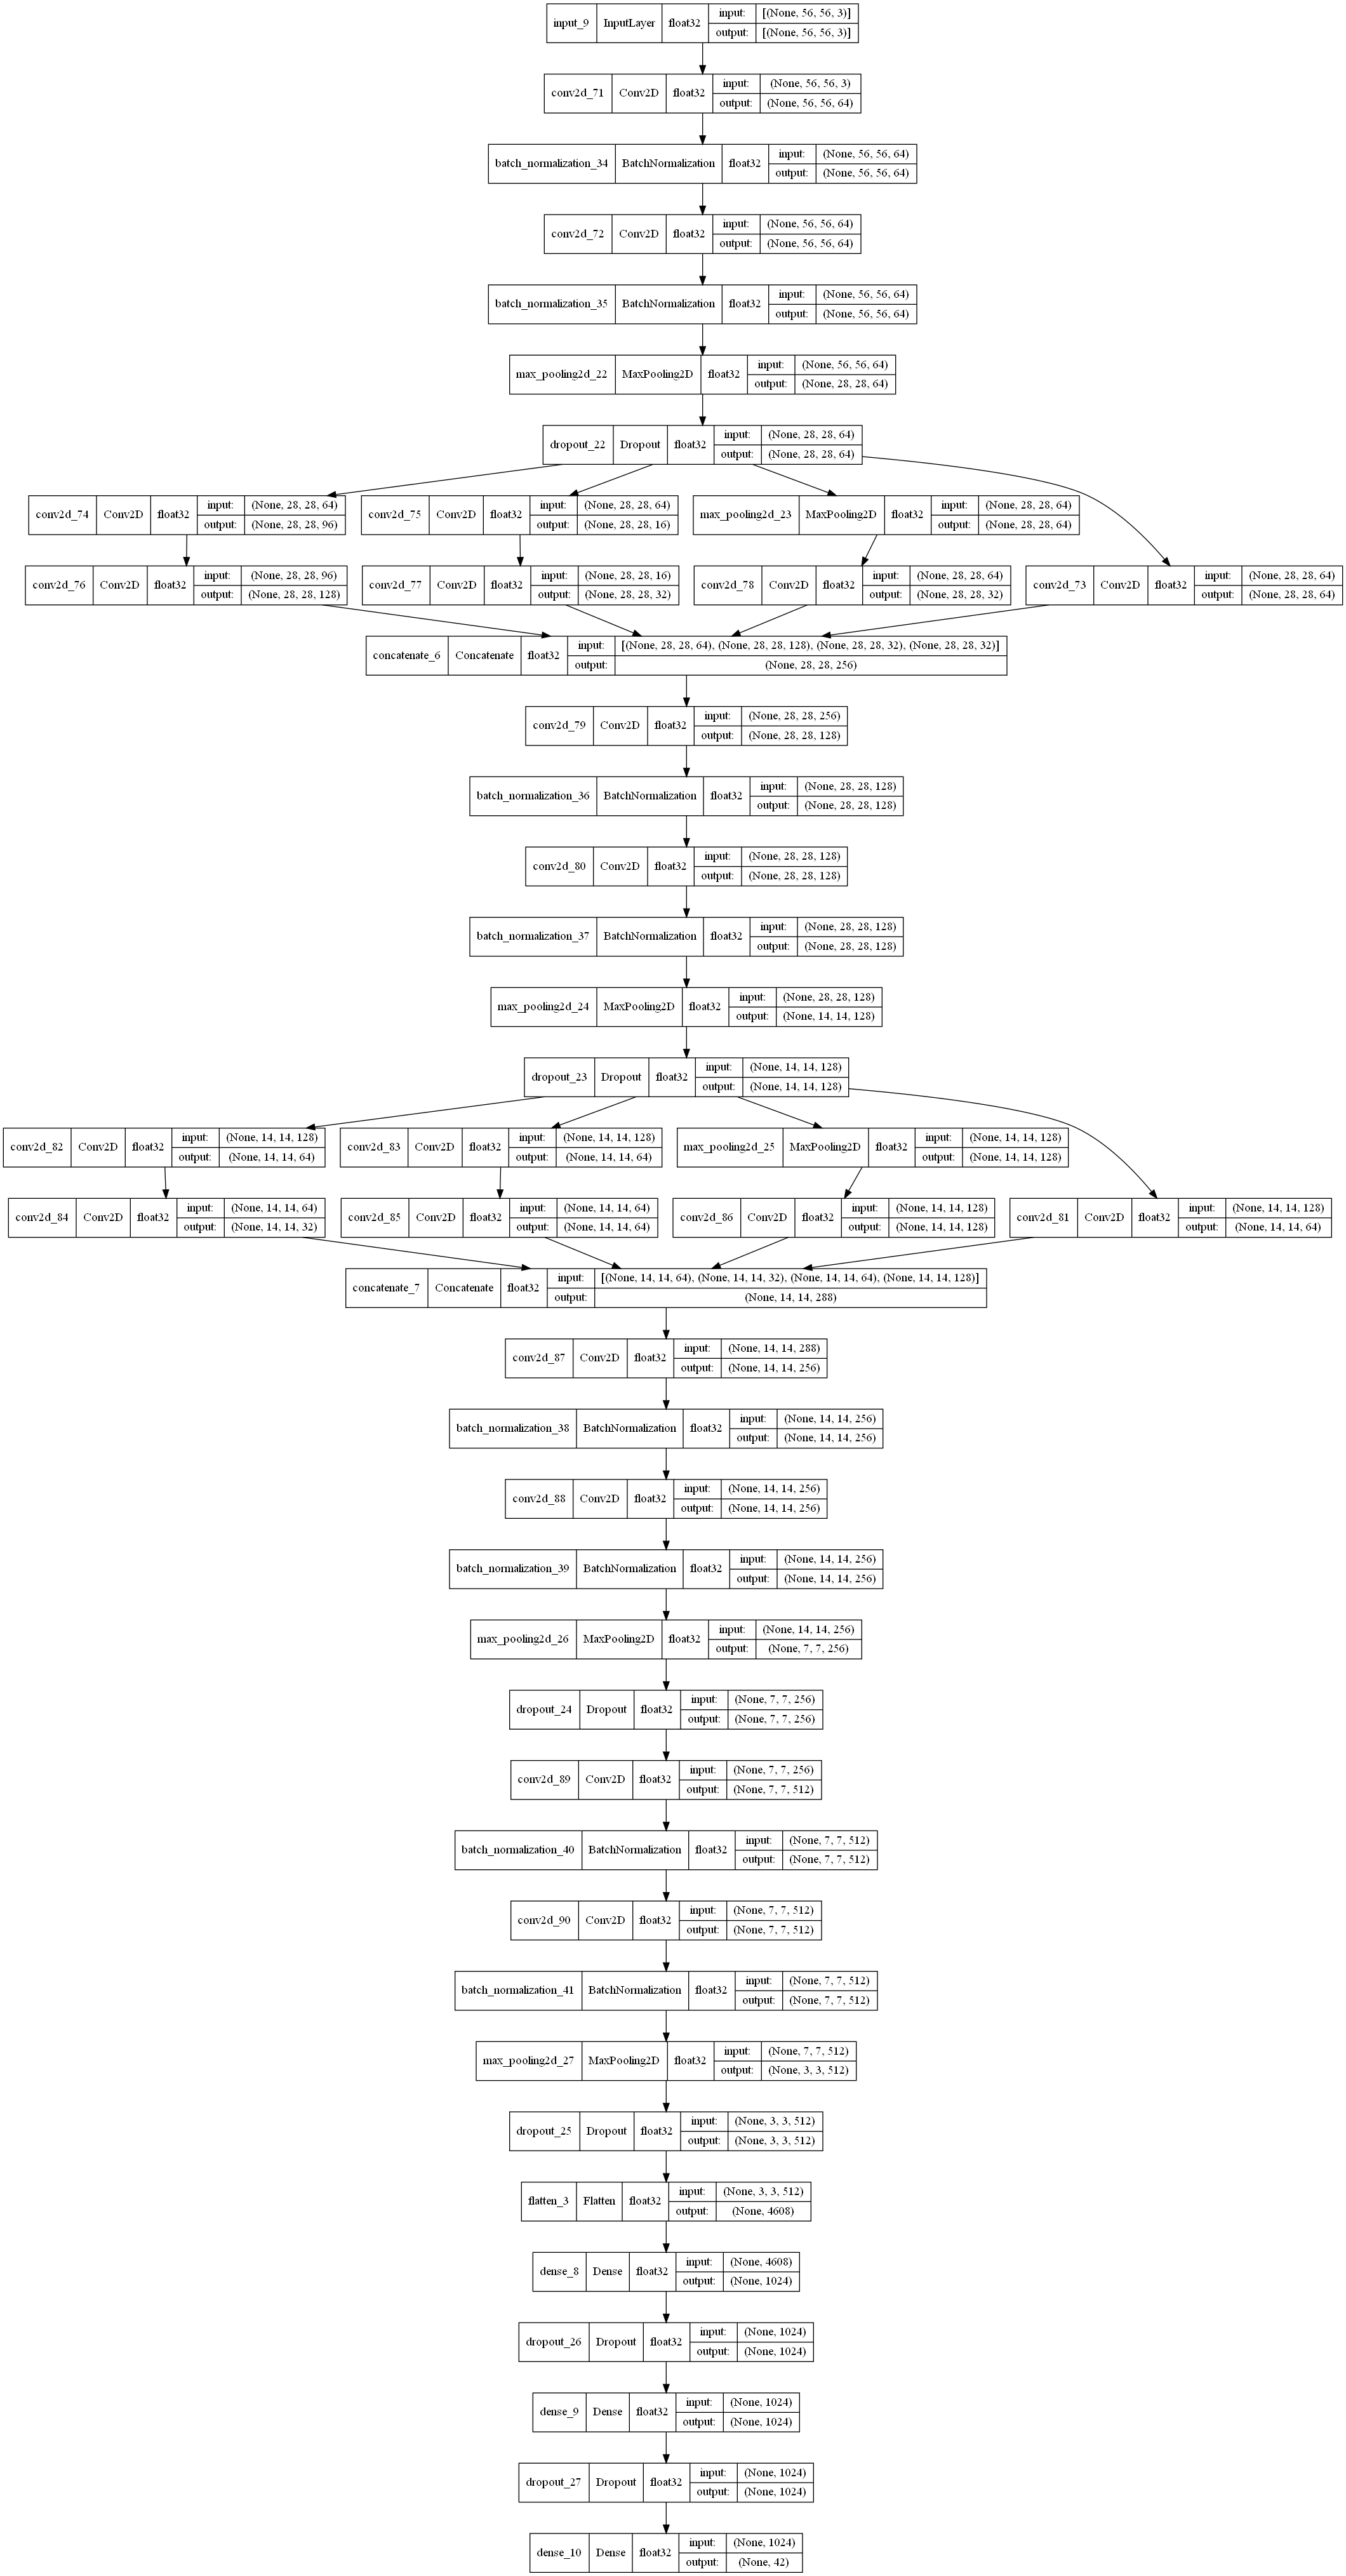

In [15]:
plot_model(exp_conv,
           to_file='baseline_conv_11_exp.png',
           show_shapes=True,
           show_dtype=True,
           show_layer_names=True)

In [ ]:
exp_conv.compile(optimizer=Adam(),
                 loss=binary_crossentropy,
                 metrics=[Recall(), Precision(), 'accuracy', AUC()])

history = exp_conv.fit(generator.flow(X, y, batch_size=64),
                       epochs=500,
                       validation_data=(val_x, val_y),
                       callbacks=[early_stop, check_pointer, reduce_lr])

In [ ]:
exp_conv.evaluate(test_x, test_y)

In [ ]:
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=[18, 6], dpi=300)
axes = axes.ravel()
epochs = list(range(len(history.history['loss'])))

sns.lineplot(x=epochs, y=history.history['loss'], ax=axes[0], label='loss')
sns.lineplot(x=epochs, y=history.history['val_loss'], ax=axes[0], label='val loss')
sns.lineplot(x=epochs, y=history.history['precision'], ax=axes[1], label='precision')
sns.lineplot(x=epochs, y=history.history['val_precision'], ax=axes[1], label='val precision')
sns.lineplot(x=epochs, y=history.history['recall'], color='#025918', ax=axes[1], label='recall')
sns.lineplot(x=epochs, y=history.history['val_recall'], color='#D9B504', ax=axes[1], label='val recall')
sns.lineplot(x=epochs, y=history.history['accuracy'], ax=axes[2], label='accuracy')
sns.lineplot(x=epochs, y=history.history['val_accuracy'], ax=axes[2], label='val accuracy')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('precision and recall')
axes[2].set_xlabel('epoch')
axes[2].set_ylabel('accuracy')
plt.savefig('VGGNet_base_conv_train_history.png')
plt.show()

In [ ]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 6], dpi=300)
axes = axes.ravel()

sns.lineplot(x=epochs, y=history.history['lr'], ax=axes[0], label='learning rate')
sns.lineplot(x=history.history['lr'], y=history.history['val_accuracy'], ax=axes[1], label='accuracy & lr')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('learning rate')
axes[1].set_xlabel('learning rate')
axes[1].set_ylabel('accuracy')

plt.savefig('VGGNet_base_conv_lr_history.png')
plt.show()

In [ ]:
# Plot confusion matrix
fig, axes = plt.subplots(nrows=13, ncols=3, figsize=[24, 56], dpi=300)
axes = axes.ravel()

preds = np.where(exp_conv.predict(test_x) < 0.65, 0, 1)
confusion = multilabel_confusion_matrix(test_y, preds)

for i, (label, matrix) in enumerate(zip(mlb.classes_, confusion)):
    labels = [f'not_{label}', label]
    sns.heatmap(matrix, annot=True, square=True, fmt='d', cbar=False, cmap='Blues',
                xticklabels=labels, yticklabels=labels, linecolor='black', linewidth=1,
                ax=axes[i])
    axes[i].set_title(labels[0])

plt.savefig('VGGNet_base_conv_7_cm.png')
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8, 24))
preds = exp_conv.predict(test_x[:10])
axes = axes.ravel()

for i in range(len(preds)):
    p = zip(list(mlb.classes_), list(preds[i]))
    p = sorted(list(p), key=lambda z: z[1], reverse=True)[:2]
    axes[i].imshow(test_x[i])
    axes[i].set_title(f'{p[0][0]}: {round(p[0][1] * 100, 2)}% \n {p[1][0]}: {round(p[1][1] * 100, 2)}%')
